# WATER BAG CLASSIFICATION - IMBALANCE AND CALIBRATION
### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [3]:
import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter, filter_by_stats
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-1': f1_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

In [4]:
from imblearn.under_sampling import RandomUnderSampler

def balanced_filtered_test_cv(X, Y, X_filt, cv_filt, seed=None, test_prct='natural'):

    X_index = np.array(range(X.shape[0]))
    out_index = X_index[~X.index.isin(X_filt.index)].tolist() # filtered out records index, only contains negative class samples

    if test_prct == 'Y':
        y_cnt = Y.value_counts(); test_prct = y_cnt[1] / y_cnt[0]
    rus = RandomUnderSampler(test_prct, random_state=seed)

    # Reuse group shuffle and include left out negative class test samples 
    cv_plus = []
    for t_idx, e_idx in cv_filt:
        t_idx_x,  e_idx_x = (X_index[X.index.isin(X_filt.iloc[idx].index)].tolist() for idx in [t_idx, e_idx]) # Convert X_filt positional index to X positional index
        left_test = e_idx_x + out_index
        x_test, y_test = Xf.iloc[left_test], Y.iloc[left_test]
        x_under, y_under = rus.fit_resample(x_test, y_test)
        y_under.index = y_test.index[rus.sample_indices_]
        left_under = X_index[X.index.isin(y_under.index)].tolist()
        cv_plus.append((t_idx_x, left_under)) 
    print_cls_cnt(Y, cv_plus[0][0], cv_plus[0][1])
    return cv_plus

In [5]:
from sklearn.metrics import precision_recall_curve

def threshold_precision_recall_plot(ye, yprob, threshold):
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    curve['f1 - 1'] = curve.mean(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
    curve.plot(ax=ax)
    
    yhat_fix = (yprob > threshold).astype('int')
    scr = pd.DataFrame(cr(ye, yhat_fix, digits=4, output_dict=True)).T
    
    return ax, scr

---
## Load & Preprocess Data

In [6]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018 to reduce imbalance
data = data[:]
group_ts = group_ts[:]

# Sample groups names per group label
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---

# Preprocessing and Data Transformation

### Feature set and target variable - X and Y

In [7]:
min_time, train_end = '2018-06', '2021-10',
eval_start, eval_end =  '2021-11', '2022-04'
top_grp = '1'
periods_ahead = 4

X = TimeseriesTransformPipeline(
    data, min_time, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate=None, fillna='mean'
); X = X[:eval_end]

Y = group_ts[str(top_grp)].loc[X.index].copy()
# groups = groupConsecutiveFlags(ts=Y)

display(Y.value_counts().to_frame('Target'))

### Target transformation
Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')

groups = groupConsecutiveFlags(ts=Y)

display(Y.value_counts().to_frame('Transformed Target'))

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


,Target
0.0,136496
1.0,783


,Transformed Target
0.0,136282
1.0,997


### Validation split

In [8]:
xt = X[:train_end]
xe = X[eval_start: eval_end]
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

### Validation statistics

In [9]:
cnts = [yt.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('\nTrain folder'); display(pd.concat(cnts, 1))

cnts = [ye.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('\nValidation folder'); display(pd.concat(cnts, 1))

eval_size = len(ye) / len(Y) * 100
eval_minority = (ye==1).sum() / (Y==1).sum() * 100
train_minority = (ye==0).sum() / (Y==0).sum() * 100
eval_stats = pd.DataFrame(
    [eval_size, train_minority, eval_minority],
    ['Samples left', 'Negative Samples left', 'Positive Samples left'],
    ['Validation (%)'],
).round(2)
display(eval_stats)

### Data leaking
display(yt.tail(3).index, ye.head(3).index)


Train folder


,Class Count,Class Count
0.0,119037,0.992777
1.0,866,0.007223



Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


,Validation (%)
Samples left,12.66
Negative Samples left,12.65
Positive Samples left,13.14


DatetimeIndex(['2021-10-31 23:15:00', '2021-10-31 23:30:00',
               '2021-10-31 23:45:00'],
              dtype='datetime64[ns]', freq=None)

DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 00:15:00',
               '2021-11-01 00:30:00'],
              dtype='datetime64[ns]', freq=None)

#### Variables:

##### X, X_eval, Y, Y_eval, groups, groups_eval

---
# Filter hour records by variables threshold

### Records left after filtering by columns' minimum thresholds

In [11]:
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, min_time, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
)

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


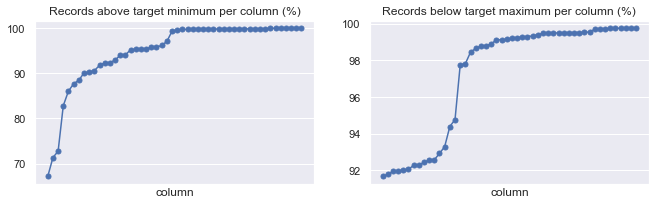

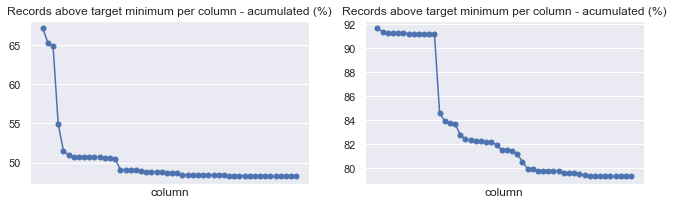

N° of columns to filter by minimum: 5
N° of columns to filter by maximum: 13



Positive minimum filter:

Records: 119903
Records left: 61796
Records left (%): 51.54 %

Positive maximum filter:

Records: 61796
Records left: 54492
Records left (%): 88.18 %



,Class Count,Percent left (%)
0.0,53626,45.05
1.0,866,100.00


In [12]:
x_filt, y_filt, groups_filt = filter_by_stats(
    X_raw.loc[xt.index], yt, groups=groups_train,
    n_filters=[None, None], choose_from=50,
    acumulate='and', top_down=True,
    figsize=(11, 3)
); x_filt = xt.loc[x_filt.index].copy()

---

# Linear models

In [10]:
from sklearn.linear_model import LinearRegression as lr, LogisticRegression as LogR

### Linear regression

In [11]:
linear_model = lr(n_jobs=-1).fit(xt, yt)

#### Test Score

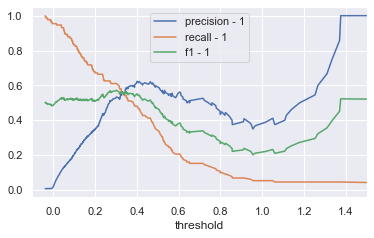

,precision,recall,f1-score,support
0.0,0.994971,0.998202,0.996584,17245.000000
1.0,0.586667,0.335878,0.427184,131.000000
accuracy,0.993209,0.993209,0.993209,0.993209
macro avg,0.790819,0.667040,0.711884,17376.000000
weighted avg,0.991893,0.993209,0.992291,17376.000000


In [12]:
yprob = linear_model.predict(xe)

ax, scr = threshold_precision_recall_plot(ye, yprob, threshold=.5)
ax.set(xlim=(-.1, 1.5))
plt.show(); display(scr)

#### Train score

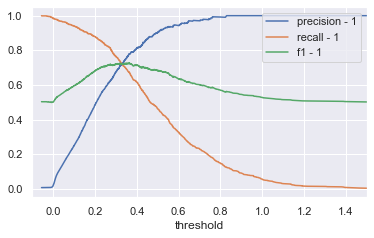

,precision,recall,f1-score,support
0.0,0.996099,0.999639,0.997866,119037.000000
1.0,0.902935,0.461894,0.611154,866.000000
accuracy,0.995755,0.995755,0.995755,0.995755
macro avg,0.949517,0.730766,0.804510,119903.000000
weighted avg,0.995426,0.995755,0.995073,119903.000000


In [13]:
yprob_train = linear_model.predict(xt)

ax, scr = threshold_precision_recall_plot(yt, yprob_train, threshold=.5)
ax.set(xlim=(-.1, 1.5))
plt.show(); display(scr)

### Linear regression - Filtered

In [14]:
linear_model = lr(n_jobs=-1).fit(x_filt, y_filt)

#### Test Score

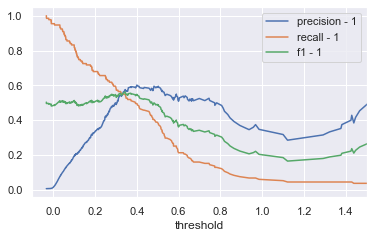

,precision,recall,f1-score,support
0.0,0.995315,0.997970,0.996641,17245.000000
1.0,0.588235,0.381679,0.462963,131.000000
accuracy,0.993324,0.993324,0.993324,0.993324
macro avg,0.791775,0.689825,0.729802,17376.000000
weighted avg,0.992246,0.993324,0.992618,17376.000000


In [15]:
yprob = linear_model.predict(xe)

ax, scr = threshold_precision_recall_plot(ye, yprob, threshold=.5)
ax.set(xlim=(-.1, 1.5))
plt.show(); display(scr)

#### Train score

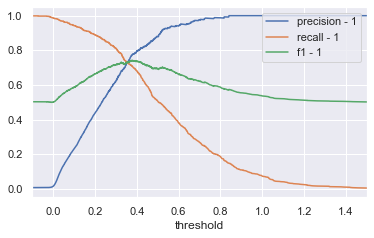

,precision,recall,f1-score,support
0.0,0.996432,0.999496,0.997962,119037.000000
1.0,0.880000,0.508083,0.644217,866.000000
accuracy,0.995947,0.995947,0.995947,0.995947
macro avg,0.938216,0.753790,0.821089,119903.000000
weighted avg,0.995591,0.995947,0.995407,119903.000000


In [16]:
yprob_train = linear_model.predict(xt)

ax, scr = threshold_precision_recall_plot(yt, yprob_train, threshold=.5)
ax.set(xlim=(-.1, 1.5))
plt.show(); display(scr)

### Logistic Regression

In [220]:
linear_model = LogR(n_jobs=-1).fit(xt, yt)

#### Test score

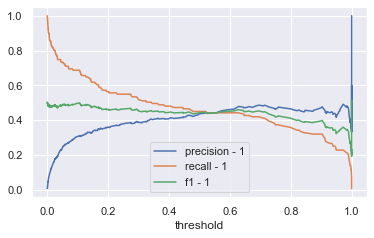

,precision,recall,f1-score,support
0.0,0.995824,0.995651,0.995738,17245.00000
1.0,0.440299,0.450382,0.445283,131.00000
accuracy,0.991540,0.991540,0.991540,0.99154
macro avg,0.718061,0.723016,0.720510,17376.00000
weighted avg,0.991636,0.991540,0.991588,17376.00000


In [221]:
yprob = linear_model.predict_proba(xe)[:, 1]

ax, scr = threshold_precision_recall_plot(ye, yprob, threshold=.5)
plt.show(); display(scr)

#### Train score

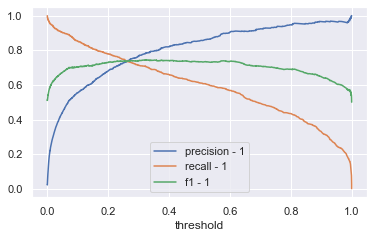

,precision,recall,f1-score,support
0.0,0.997183,0.999244,0.998212,119037.000000
1.0,0.854839,0.612009,0.713324,866.000000
accuracy,0.996447,0.996447,0.996447,0.996447
macro avg,0.926011,0.805627,0.855768,119903.000000
weighted avg,0.996155,0.996447,0.996155,119903.000000


In [222]:
yprob_train = linear_model.predict_proba(xt)[:, 1]

ax, scr = threshold_precision_recall_plot(yt, yprob_train, threshold=.5)
plt.show(); display(scr)

---
# Ensemble models

## True proportion - GBC

In [ ]:
model = gbc(random_state=0, verbose=1)
model.fit(xt, yt)

In [8]:
from sklearn.metrics import precision_recall_fscore_support

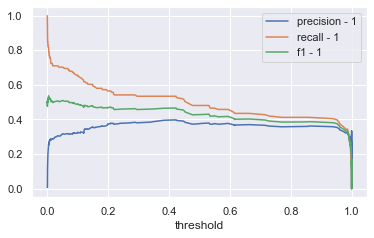

,precision,recall,f1-score,support
0.0,0.996453,0.993853,0.995152,17245.000000
1.0,0.397727,0.534351,0.456026,131.000000
accuracy,0.990389,0.990389,0.990389,0.990389
macro avg,0.697090,0.764102,0.725589,17376.000000
weighted avg,0.991940,0.990389,0.991087,17376.000000


In [25]:
yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)

ax, scr = threshold_precision_recall_plot(ye, yprob, threshold=.4)
plt.show(); display(scr)

## Filtered data - GBC

In [68]:
model_filt = classifiers['SVC'](probability=True)
model_filt.fit(x_filt, y_filt)

SVC(probability=True)

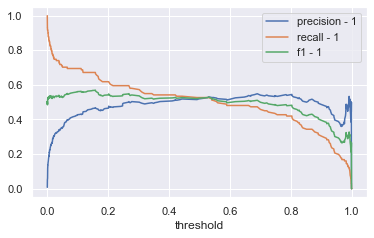

,precision,recall,f1-score,support
0.0,0.997093,0.994607,0.995849,17245.00000
1.0,0.465517,0.618321,0.531148,131.00000
accuracy,0.991770,0.991770,0.991770,0.99177
macro avg,0.731305,0.806464,0.763498,17376.00000
weighted avg,0.993086,0.991770,0.992345,17376.00000


In [35]:
yprob_filt = pd.Series(model_filt.predict_proba(xe)[:, 1], index=xe.index)
ax, scr = threshold_precision_recall_plot(ye, yprob_filt, 0.2)
plt.show(); display(scr)

---
# Undersample analysis

## Filtered sample proportion - GBC

In [38]:
filt_prct = 1 / y_filt.mean() - 1

,Train set,Test set
Class,,
0.0,42851,23917
1.0,692,174


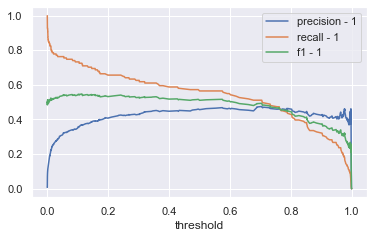

,precision,recall,f1-score,support
0.0,0.996689,0.994897,0.995792,17245.000000
1.0,0.456790,0.564885,0.505119,131.000000
accuracy,0.991655,0.991655,0.991655,0.991655
macro avg,0.726739,0.779891,0.750456,17376.000000
weighted avg,0.992618,0.991655,0.992093,17376.000000


In [39]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
#     train_size=None, test_size=None,
    train_prct=filt_prct, test_prct='natural',
    random_state=0,
)

cv_base = list(splitter.split(
    xt, yt, groups_train,
    strategy='GroupKFold'
)); print_cls_cnt(yt, cv_base[0][0], cv_base[0][1])

model = gbc(n_estimators=100, random_state=0, verbose=0)
model.fit(xt.iloc[cv_base[0][0]], yt.iloc[cv_base[0][0]])

yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)

ax, scr = threshold_precision_recall_plot(ye, yprob, 0.5)
plt.show(); display(scr)

## Filtered sample - GBC

,Train set,Test set
Class,,
0.0,13840,10683
1.0,692,174


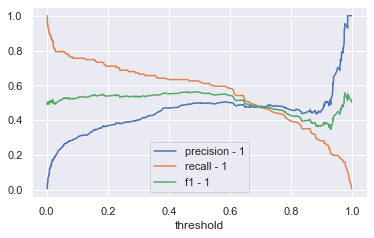

,precision,recall,f1-score,support
0.0,0.997095,0.995245,0.996169,17245.000000
1.0,0.496933,0.618321,0.551020,131.000000
accuracy,0.992403,0.992403,0.992403,0.992403
macro avg,0.747014,0.806783,0.773595,17376.000000
weighted avg,0.993324,0.992403,0.992813,17376.000000


In [263]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=None, test_size=None,
    train_prct=20, test_prct='natural',
    random_state=0,
)

cv_filt = list(splitter.split(
    x_filt, y_filt, groups_filt,
    strategy='GroupKFold'
)); print_cls_cnt(y_filt, cv_filt[0][0], cv_filt[0][1])

model_filt = gbc(n_estimators=100, random_state=0, verbose=0)
model_filt.fit(x_filt.iloc[cv_filt[0][0]], y_filt.iloc[cv_filt[0][0]])

yprob_filt = pd.Series(model_filt.predict_proba(xe)[:, 1], index=xe.index)
ax, scr = threshold_precision_recall_plot(ye, yprob_filt, 0.5)
plt.show(); display(scr)

---
# Save Final Model

#### Refilter by positive samples min and max values

In [8]:
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, min_time, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
)

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


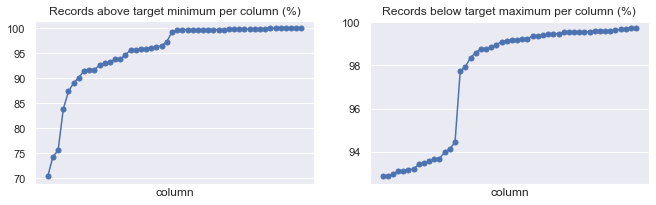

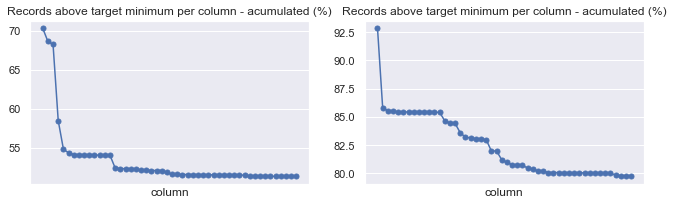

N° of columns to filter by minimum: 5
N° of columns to filter by maximum: 2



Positive minimum filter:

Records: 142865
Records left: 78362
Records left (%): 54.85 %

Positive maximum filter:

Records: 78362
Records left: 69354
Records left (%): 88.5 %



,Class Count,Percent left (%)
0.0,68357,48.18
1.0,997,100.00


In [50]:
X_filt, Y_filt, Groups_filt = filter_by_stats(
    X_raw, Y, groups=groups,
    n_filters=[None, None], choose_from=50,
    acumulate='and', top_down=True,
    figsize=(11, 3)
); X_filt = X.loc[X_filt.index].copy()

#### Fit model

In [51]:
final_model = gbc(random_state=0).fit(X_filt, Y_filt)

In [57]:
final_model.score(x_filt, y_filt)

0.9963297364750789

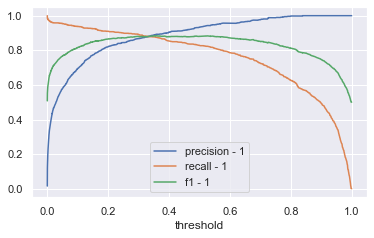

,precision,recall,f1-score,support
0.0,0.997652,0.998545,0.998099,53626.000000
1.0,0.904645,0.854503,0.878860,866.000000
accuracy,0.996256,0.996256,0.996256,0.996256
macro avg,0.951149,0.926524,0.938479,54492.000000
weighted avg,0.996174,0.996256,0.996204,54492.000000


In [59]:
yprob = pd.Series(final_model.predict_proba(x_filt)[:, 1], index=x_filt.index)

ax, scr = threshold_precision_recall_plot(y_filt, yprob, threshold=.4)
plt.show(); display(scr)

In [55]:
import pickle

model_path = 'API Deploy/Modelos/'
model_name = 'Catete/ModeloBolsõesCatete.pickle'
pickle.dump(final_model, open(model_path + model_name, 'wb'))

### Save model deployment transformation info

#### Transformation steps:
0. Reshape apis response to flat format
1. Drop non-included columns (empty excluded columns)
1. Scale all columns based on 'X' sample min and max values
1. Fill missing values with sample min values

In [61]:
# Save Features description
X_info = X_raw.describe().loc[['min', 'max', 'mean']].T
X_info.to_csv('API Deploy/Modelos/Catete/InformaçõesDeployCatete.csv', index=True)

display(X_info.head(), X_info.shape)

,min,max,mean
acumulado_chuva_1_h - A602,0.0,97.2,0.141022
pressao_minima - A602,999.3,1030.7,1013.874034
temperatura - A602,11.2,38.9,23.435761
pressao_maxima - A602,999.4,1031.0,1014.369306
pressao - A602,999.3,1030.9,1014.122910


(217, 3)

---
# Model visualization

In [122]:
model = gbc(n_estimators=100, subsample=.75, random_state=0, max_depth=5, verbose=1)
model.fit(x_filt, y_filt)
yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0709           0.0728            2.10m
         2           0.0634           0.0055            2.11m
         3           0.0602           0.0040            2.13m
         4           0.0570           0.0027            2.08m
         5           0.0530           0.0017            2.12m
         6           0.0497           0.0031            2.17m
         7           0.0457           0.0015            2.16m
         8           0.0411           0.0021            2.20m
         9           0.0412           0.0013            2.25m
        10           0.0391           0.0010            2.28m
        20           0.0268           0.0003            2.01m
        30           0.0201           0.0001            1.73m
        40           0.0172           0.0000            1.45m
        50           0.0161           0.0001            1.19m
        60           0.0130           0.0001           57.02s
       

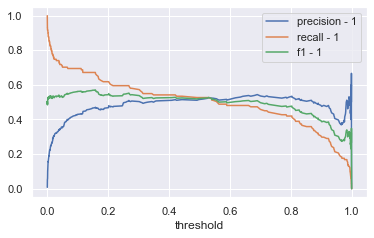

,precision,recall,f1-score,support
0.0,0.996922,0.995361,0.996141,17245.000000
1.0,0.493671,0.595420,0.539792,131.000000
accuracy,0.992346,0.992346,0.992346,0.992346
macro avg,0.745296,0.795390,0.767967,17376.000000
weighted avg,0.993128,0.992346,0.992700,17376.000000


In [107]:
ax, scr = threshold_precision_recall_plot(ye, yprob, 0.25)
plt.show(); display(scr)

### Calibration curve

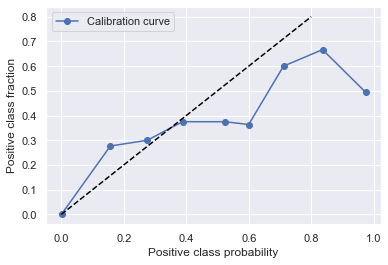

In [60]:
from sklearn.calibration import calibration_curve

cal_curve = calibration_curve(ye, yprob, n_bins=9, strategy='uniform')
xx = np.linspace(0, .8)
calibration = pd.Series(cal_curve[0], index=cal_curve[1]).to_frame('Calibration curve')
ax = calibration.plot(marker='o')
ax.plot(xx, xx, color='black', ls='dashed')
ax = ax.set(ylabel='Positive class fraction', xlabel='Positive class probability')

### Probability Distribution

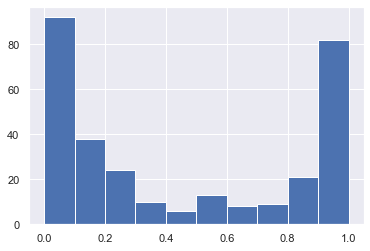

In [101]:
ax = yprob[yprob>0.03].hist(bins=np.linspace(0, 1, 11))

### Probability prediction

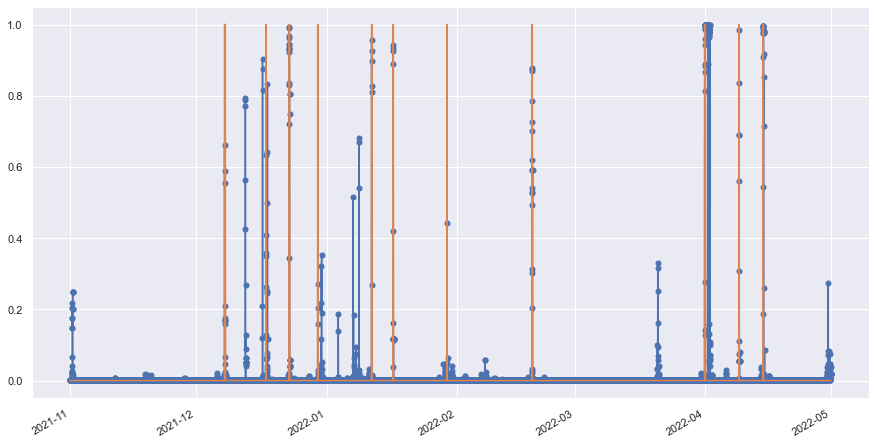

In [96]:
fig = plt.figure(figsize=(15, 8))
yprob.sort_values().plot(marker='o', ms=5)
ye.plot()

### Probability inspection

In [97]:
def calibrate(prob, threshold=.5):
    if type(prob) is float:
        if prob < threshold:
            return 0.5 * prob / threshold
        else:
            return 0.5 + 0.5 * (prob - threshold) / (1 - threshold)
    if type(threshold) is float:
        threshold = [threshold] * len(prob)
    if type(prob) is np.ndarray:
        return np.array(list(map(calibrate, prob, threshold)))
    elif type(prob) is pd.Series:
        return pd.Series(list(map(calibrate, prob, threshold)), index=prob.index)

pred_cmap = lambda pred, true_value: 'red' if pred!=true_value else ('green' if true_value==1 else (0,0,0,0))

def prediction_probability_plot(yprob, y, threshold=0.5, start=None, end=None, figsize=(12, 6), path=None, ax=None):
    
    if start is None: start = y.index.min()
    if end is None: end = y.index.max()
    
    yhat = (yprob > threshold).astype('int')
    
    prob_msk = (yprob.index > start) & (yprob.index < end)
    msk = (y.index > start) & (y.index < end)

    colors = list(map(pred_cmap, yhat[msk], y[msk]))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    yprob[prob_msk].plot(ax=ax)
    y[msk].plot(ax=ax, color='orange', lw=1, alpha=.75)
    y_pos = y[msk][y[msk]==1]
    if len(y_pos): y_pos.plot(ax=ax, ms=5, marker='o', color='orange', lw=0)
    ax.scatter(
        yprob.index[prob_msk], yprob[prob_msk], s=30,
        color=colors
    )
    ax.set(title='Predicted positive probability\n{} - {} threshold: {}'.format(start.date().isoformat(), end.date().isoformat(), round(threshold, 2)))
    if path is not None:
        plt.savefig(path.format(start.date().isoformat(), end.date().isoformat(), round(threshold, 2)))
    return ax    

import warnings; warnings.filterwarnings('ignore')

def multi_prediction_probability_plot(yprob, ye, threshold, dates, path=None, prob_path=None):
    yprob_cal = calibrate(yprob, threshold)
    fig, axs = plt.subplots(len(dates)//3+1, 3, figsize=(16, 14), tight_layout=True); axs = axs.reshape(-1)
    for i, date in enumerate(dates[:]):
        start, end = date
        prediction_probability_plot(yprob_cal, ye, threshold, start, end, path=None, ax=axs[i])
    if path is not None: plt.savefig(path)
    plt.show()

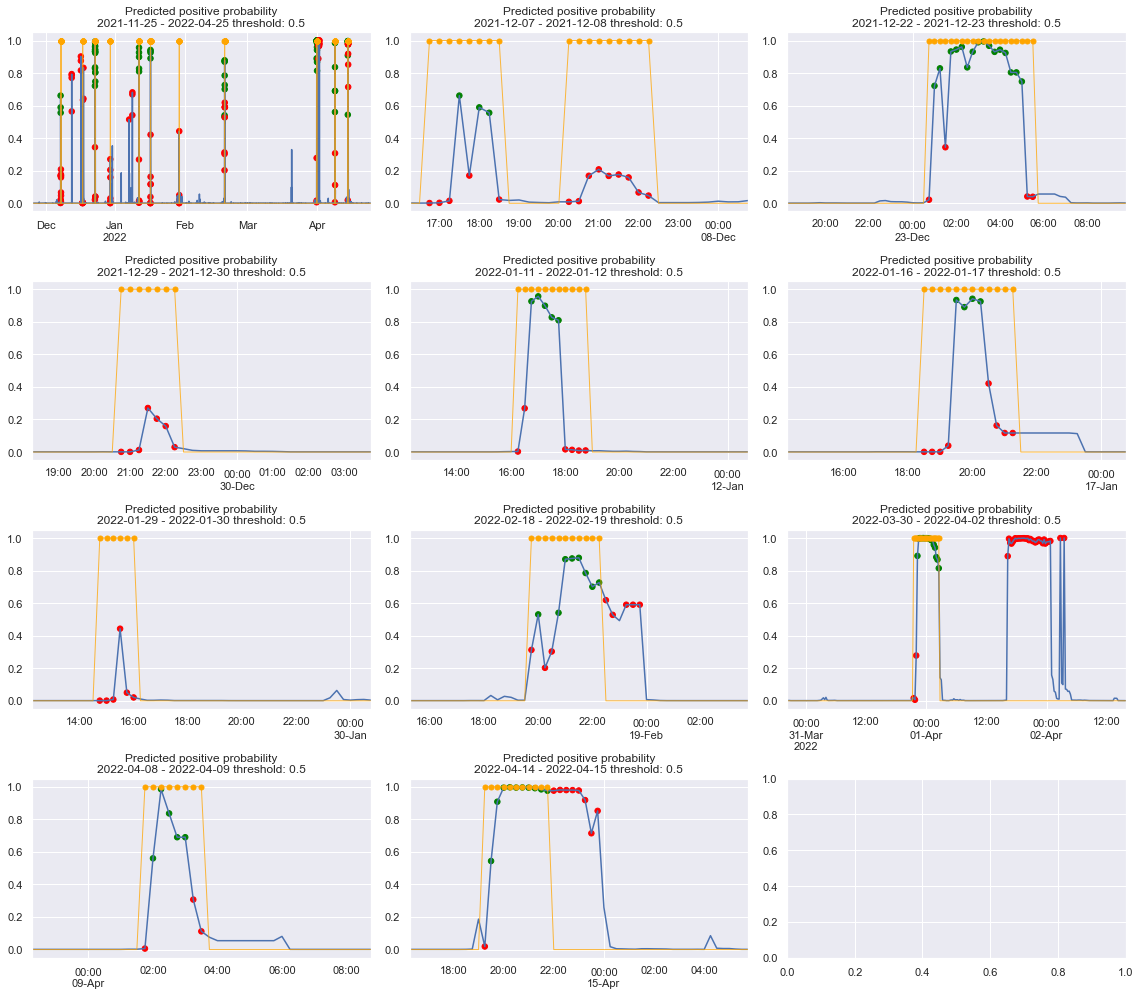

In [100]:
import warnings; warnings.filterwarnings('ignore')
dates = [
    (pd.datetime(2021, 11, 25), pd.datetime(2022, 4, 25)),
    (pd.datetime(2021, 12, 7, 16), pd.datetime(2021, 12, 8, 1)), 
    (pd.datetime(2021, 12, 22, 18), pd.datetime(2021, 12, 23, 10)), 
    (pd.datetime(2021, 12, 29, 18), pd.datetime(2021, 12, 30, 4)), 
    (pd.datetime(2022, 1, 11, 12), pd.datetime(2022, 1, 12, 1)), 
    (pd.datetime(2022, 1, 16, 14), pd.datetime(2022, 1, 17, 1)), 
    (pd.datetime(2022, 1, 29, 12), pd.datetime(2022, 1, 30, 1)), 
    (pd.datetime(2022, 2, 18, 15), pd.datetime(2022, 2, 19, 4)), 
    (pd.datetime(2022, 3, 30, 20), pd.datetime(2022, 4, 2, 16)),
    (pd.datetime(2022, 4, 8, 22), pd.datetime(2022, 4, 9, 9)),
    (pd.datetime(2022, 4, 14, 16), pd.datetime(2022, 4, 15, 6)),
#     (pd.datetime(2022, 4, 5, 16), pd.datetime(2022, 5, 1, 22))
]

yprob_cal = calibrate(yprob, 0.5)
prob_path = 'Modelagem de Bolsões/Results/Probabilidade/catete_prob_plot_{}_{}_{}.png'

multi_prediction_probability_plot(yprob, ye, 0.5, dates, path=None, prob_path=None)

---
# Hyperparamteter tunning

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]